In [4]:
import graph_tool.all as gt
import os

def build_dag_from_str(g_str):
    g_elements=g_str.split('\n')[:-1]
    g = gt.Graph(directed=True)
    status = g.new_vertex_property("int")
    ops = g.new_vertex_property("string")
    inputs = g.new_vertex_property("string")
    
    for g_e in g_elements:
        command, params = g_e.split(',', 1)

        if command == 'v':
            vid,operation, inputdir = params.split(',')
            v = g.add_vertex()
            status[v] = 0
            ops[v] = operation
            inputs[v] = inputdir
        elif command == 'e':
            src, dest = params.split(',')
            g.add_edge(src, dest)
    g.vp['status'] = status;
    g.vp['ops'] = ops;
    g.vp['inputdir'] = inputs
    return g;


def submit(g, ready=[]):
    print(ready)
    process = []
    for v in ready:
        program = g.vp['ops'][v]
        inputdir = g.vp['inputdir'][v]
        
        cur_dir = os.getcwd()
        cfg_hibench_root='/local0/HiBench'
        
        cfg_executable = 'bin/workloads/micro/%s/hadoop/run2.sh'%(program)
        
        process.append(subprocess.Popen([cfg.hibench_command, inputdir], 
                                        stdout=subprocess.PIPE, shell=True, executable="/bin/bash"))

    print('Wait for ', cfg.grace_time)
    time.sleep(cfg.grace_time)

    # get app name
    app = yarn.get_appname();

    exit_codes = [p.wait() for p in process]
    
    print(exit_codes)
    
    os.chdir(cfg_hibench_root)
        
    os.chdir(cur_dir)
    


def schedule(g):
    sort = gt.topological_sort(g)
    schedule = 1;
    to_be_executed = []
    for v in sort:
        # get in-degree neighbors
        schedule = 1; 
        in_neight_vrtx = g.get_in_neighbors(v)
        for nv in in_neight_vrtx:
            if g.vp.status[nv] == 0:
                schedule = 0;
        if schedule:
            to_be_executed.append(v) 
    return to_be_executed

with open('graphs.g', 'r') as fd:
    graph_strs = fd.read().split('#')[1:]
    
    for g_str in graph_strs:
        g = build_dag_from_str(g_str)
        
        to_be_executed = schedule(g)
        
        submit(g, to_be_executed)

[1, 0]
bin/workloads/micro/wordcount/hadoop/run2.sh s3a://data/HiBench/Wordcount/Input-1G-1
bin/workloads/micro/wordcount/hadoop/run2.sh s3a://data/HiBench/Wordcount/Input-1G
[3, 1, 0]
bin/workloads/micro/wordcount/hadoop/run2.sh 32G
bin/workloads/micro/wordcount/hadoop/run2.sh 32G
bin/workloads/micro/wordcount/hadoop/run2.sh 32G


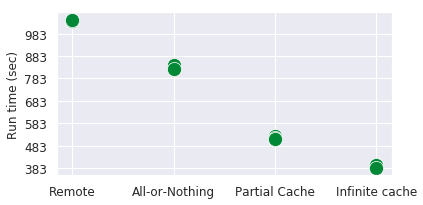

In [9]:
import pandas as pd 
import seaborn as sns; 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def assign_experiment_id(row):
    map_name_to_id = {'remote': 0, 'allnothing': 1, 'partial': 2, 'allcached': 3}
    row['experiemnt_id'] = map_name_to_id[row['experiment']]
    return row

df = pd.read_csv('../aon_vs_partial.csv')
df = df.apply(assign_experiment_id, axis=1)

sns.set(color_codes=True)

def format_xticks(x, pos=None):
    decoder = {0: 'Remote', 1: 'All-or-Nothing', 2: 'Partial Cache', 3: 'Infinite cache'}
    return decoder[x]



fig, ax = plt.subplots(figsize=(6,3))
sns.scatterplot(ax=ax, x='experiemnt_id', y = 'runtime' , data=df,
                s=200, color="#008837")

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks(range(df['runtime'].min(), df['runtime'].max(), 100))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.set_xlabel('')
ax.set_ylabel("Run time (sec)") 

plt.show()

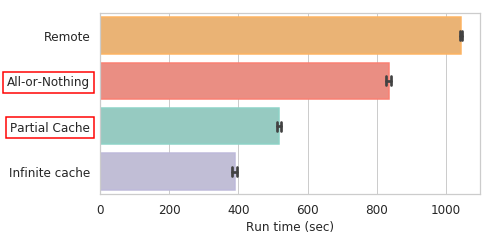

In [10]:
sns.set_style("whitegrid")
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(ax=ax, y='experiemnt_id', x = 'runtime', data=df,
            capsize=.2, palette=['#fdb462', '#fb8072', '#8dd3c7' , '#bebada'], 
            orient = 'h', edgecolor=['#fdb462', '#fb8072', '#8dd3c7', '#bebada'])

ax.set_yticks([0, 1, 2, 3])
#ax.set_yticks(range(df['runtime'].min(), df['runtime'].max(), 100))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.set_ylabel('')
ax.set_xlabel("Run time (sec)") 

label = ax.yaxis.get_ticklabels()[1]
label.set_bbox(dict(facecolor='none', edgecolor='red'))

label = ax.yaxis.get_ticklabels()[2]
label.set_bbox(dict(facecolor='none', edgecolor='red'))

plt.subplots_adjust(left=0.1, bottom=0.13, right=0.98, top=0.97)
plt.savefig('/local0/papers/KARIZ/OSDI20/Figures/fig_partial_vs_allnothing.pdf', format='pdf', dpi=200)
plt.savefig('/local0/papers/KARIZ/OSDI20/Figures/fig_partial_vs_allnothing.png', format='png', dpi=200)


plt.show()